## Data Dictionary
Variable | Definition | Key
---------|------------|--------
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex	
Age | Age in years	
sibsp | # of siblings / spouses aboard the Titanic	
parch | # of parents / children aboard the Titanic	
ticket | Ticket number	
fare | Passenger fare	
cabin | Cabin number	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton


## Variable Notes
`pclass`: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

`age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

`sibsp`: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

`parch`: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

## Setup

In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Investigations

In [57]:
# read raw
# raw_df = pd.read_csv('/kaggle/input/titanic/train.csv')
raw_df = pd.read_csv('./data/train.csv')


In [58]:
def val_contains_any(val, list):
    for item in list:
        if item in val:
            return True
    return False
def is_parent(row):
    if row['Parch'] > 0:
        if (row['is_age_mister'] == 1) or (row['is_age_misses'] == 1):
            return True
    return False
def is_child(row):
    if row['Parch'] > 0:
        if (row['is_age_master'] == 1) or (row['is_age_miss'] == 1):
            return True
    return False
def age_cat(row):
    if row['is_age_master']: return "master"
    if row['is_age_miss']: return "miss"
    if row['is_age_misses']: return "misses"
    return "mister"

df = raw_df
df['is_female']           = df["Sex"].map(lambda x: 1 if x == "female" else 0)

df['has_raw_age']         = df["Age"].map(lambda x: 1 if x > 0 else 0)
df['is_age_estimated']    = df["Age"].map(lambda x: 1 if ".5" in str(x) else 0)
df['is_age_infant']       = df["Age"].map(lambda x: 1 if x < 1 else 0)
df['is_age_child']        = df["Age"].map(lambda x: 1 if x >= 1 and x < 13 else 0)
df['is_age_teen']         = df["Age"].map(lambda x: 1 if x >= 13 and x < 20 else 0)
df['is_age_young_adult']  = df["Age"].map(lambda x: 1 if x >= 20 and x < 27 else 0)
df['is_age_adult']        = df["Age"].map(lambda x: 1 if x >= 27 and x < 45 else 0)
df['is_age_old_adult']    = df["Age"].map(lambda x: 1 if x >= 45 and x < 65 else 0)
df['is_age_elderly']      = df["Age"].map(lambda x: 1 if x >= 65 else 0)
# age groups
df['is_age_master']       = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Master."]) else 0)
df['is_age_mister']       = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Mr.", "Mister.","Dr.","Don.","Rev.","Col.","Capt.","Major.","Sir.","Jonkheer."]) else 0)
df['is_age_miss']         = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Miss.","Ms.","Mlle."]) else 0)
df['is_age_misses']       = df["Name"].map(lambda x: 1 if val_contains_any(x, ["Mrs.","Mme.","Countess.","Lady."]) else 0)
df['raw_age']             = df['Age']

master_age_mean           = df[(df['is_age_master'] == 1) & (df["has_raw_age"] == 1)]['Age'].mean()
mister_age_mean           = df[(df['is_age_mister'] == 1) & (df["has_raw_age"] == 1)]['Age'].mean()
miss_age_mean             = df[(df['is_age_miss'] == 1)   & (df["has_raw_age"] == 1)]['Age'].mean()
misses_age_mean           = df[(df['is_age_misses'] == 1) & (df["has_raw_age"] == 1)]['Age'].mean()

df['Age']                 = np.where((df['is_age_master']==1) & (df['Age'].isna()), master_age_mean, df['Age'])
df['Age']                 = np.where((df['is_age_mister']==1) & (df['Age'].isna()), mister_age_mean, df['Age'])
df['Age']                 = np.where((df['is_age_miss']==1)   & (df['Age'].isna()), miss_age_mean, df['Age'])
df['Age']                 = np.where((df['is_age_misses']==1) & (df['Age'].isna()), misses_age_mean, df['Age'])

df['is_family']           = df.apply(lambda x: 1 if x['SibSp'] > 0 or x['Parch'] > 0 else 0, axis=1)
df['is_parent']           = df.apply(lambda x: 1 if is_parent(x) else 0, axis=1)
df['is_child']            = df.apply(lambda x: 1 if is_child(x) else 0, axis=1)

df['age_cat']             = df.apply(lambda x: age_cat(x), axis=1)

## 
## CLEAN-UP
# 2 people with no embarked are hard to match with other values, drop them
df                        = df[df["Embarked"].isna() == False]


In [59]:
    # 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
    # 'Fare', 'Cabin', 'Embarked', 'is_female',
    # 'has_raw_age', 'is_age_estimated', 'is_age_infant', 'is_age_child',
    # 'is_age_teen', 'is_age_young_adult', 'is_age_adult', 'is_age_old_adult',
    # 'is_age_elderly', 'is_age_master', 'is_age_mister', 'is_age_miss',
    # 'is_age_misses', 'raw_age', 'is_family'
    # 'SibSp', 'Parch', 
# trmming down
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 
                      'Cabin', 'raw_age', 
                      'has_raw_age','is_age_estimated',
                      'SibSp', 'Parch'])


In [60]:
df['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 247, dtype: int64

In [61]:
# ## Prove that our Age Groups all have Ages

# def get_age_groups(df, field):
#     all_df = df[df[field] == 1]
#     no_age_df = all_df[all_df["Age"].isna()]
#     age_df = all_df[all_df["Age"].isna() == False]
#     return all_df, age_df, no_age_df

# def print_lengths(pref, all_df, age_df, no_age_df):
#     print(f"{pref:>6} a:{len(all_df):>6} w:{len(age_df):>6} no:{len(no_age_df):>6}")
    
# (masters_df, masters_age_df, masters_no_age_df) = get_age_groups(df, "is_age_master")
# (misters_df, misters_age_df, misters_no_age_df) = get_age_groups(df, "is_age_mister")
# (miss_df, miss_age_df, miss_no_age_df) = get_age_groups(df, "is_age_miss")
# (misses_df, misses_age_df, misses_no_age_df) = get_age_groups(df, "is_age_misses")

# print_lengths("master", masters_df, masters_age_df, masters_no_age_df)
# print_lengths("mr", misters_df, misters_age_df, misters_no_age_df)
# print_lengths("miss", miss_df, miss_age_df, miss_no_age_df)
# print_lengths("mrs", misses_df, misses_age_df, misses_no_age_df)
                  
# print(f"{len(masters_df) + len(misters_df) + len(miss_df) + len(misses_df) }  total by breakdown")
# print(f"{len(df) }  total raw")

# Investigations

In [62]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,is_female,is_age_infant,is_age_child,is_age_teen,...,is_age_old_adult,is_age_elderly,is_age_master,is_age_mister,is_age_miss,is_age_misses,is_family,is_parent,is_child,age_cat
0,0,3,male,22.0,7.2500,S,0,0,0,0,...,0,0,0,1,0,0,1,0,0,mister
1,1,1,female,38.0,71.2833,C,1,0,0,0,...,0,0,0,0,0,1,1,0,0,misses
2,1,3,female,26.0,7.9250,S,1,0,0,0,...,0,0,0,0,1,0,0,0,0,miss
3,1,1,female,35.0,53.1000,S,1,0,0,0,...,0,0,0,0,0,1,1,0,0,misses
4,0,3,male,35.0,8.0500,S,0,0,0,0,...,0,0,0,1,0,0,0,0,0,mister


In [63]:
df.count()

Survived              889
Pclass                889
Sex                   889
Age                   889
Fare                  889
Embarked              889
is_female             889
is_age_infant         889
is_age_child          889
is_age_teen           889
is_age_young_adult    889
is_age_adult          889
is_age_old_adult      889
is_age_elderly        889
is_age_master         889
is_age_mister         889
is_age_miss           889
is_age_misses         889
is_family             889
is_parent             889
is_child              889
age_cat               889
dtype: int64

# Investigations

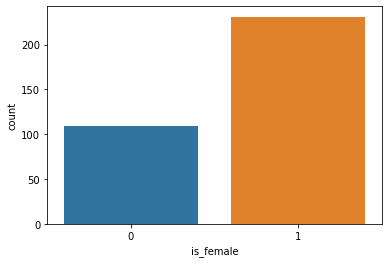

In [64]:
surv_df = df[df["Survived"] == 1]
ax = sns.countplot(x="is_female", data=surv_df)
# surv_df["Sex"].value_counts().plot(kind="bar")

In [65]:
def count_plot(df, field, title_prefix="Survived"):
    plt.figure(figsize=(20,5),dpi=100)
    sns.countplot(x=field, 
                  data=surv_df, 
                        order=surv_df[field].value_counts().index).set_title(f"{title_prefix} : {field}")

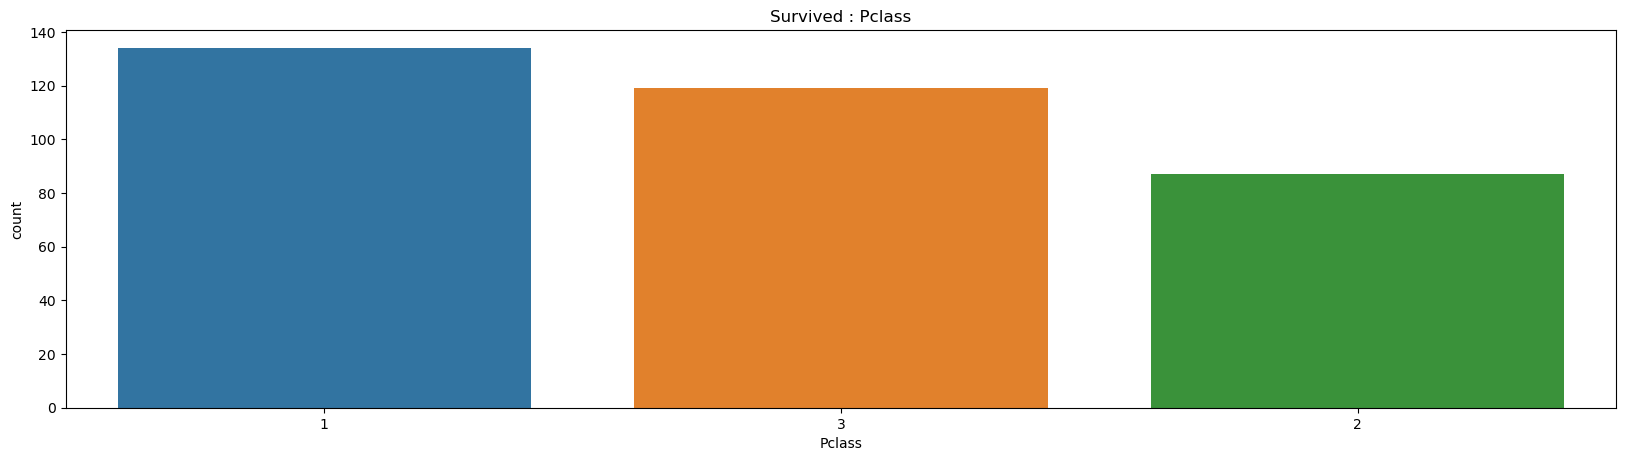

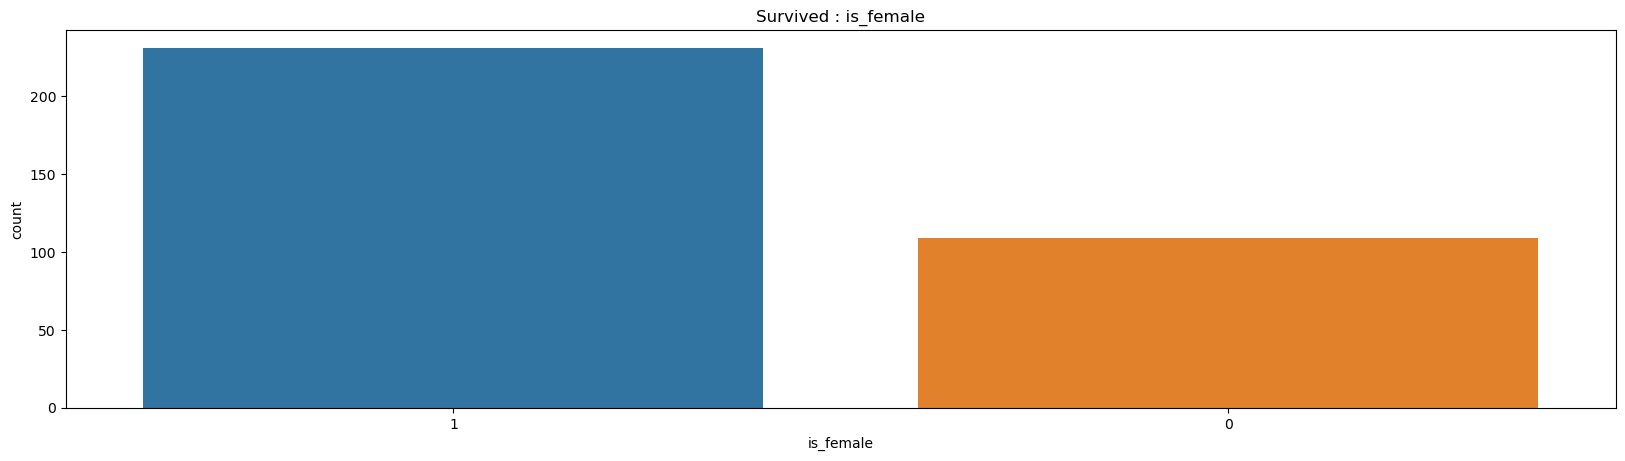

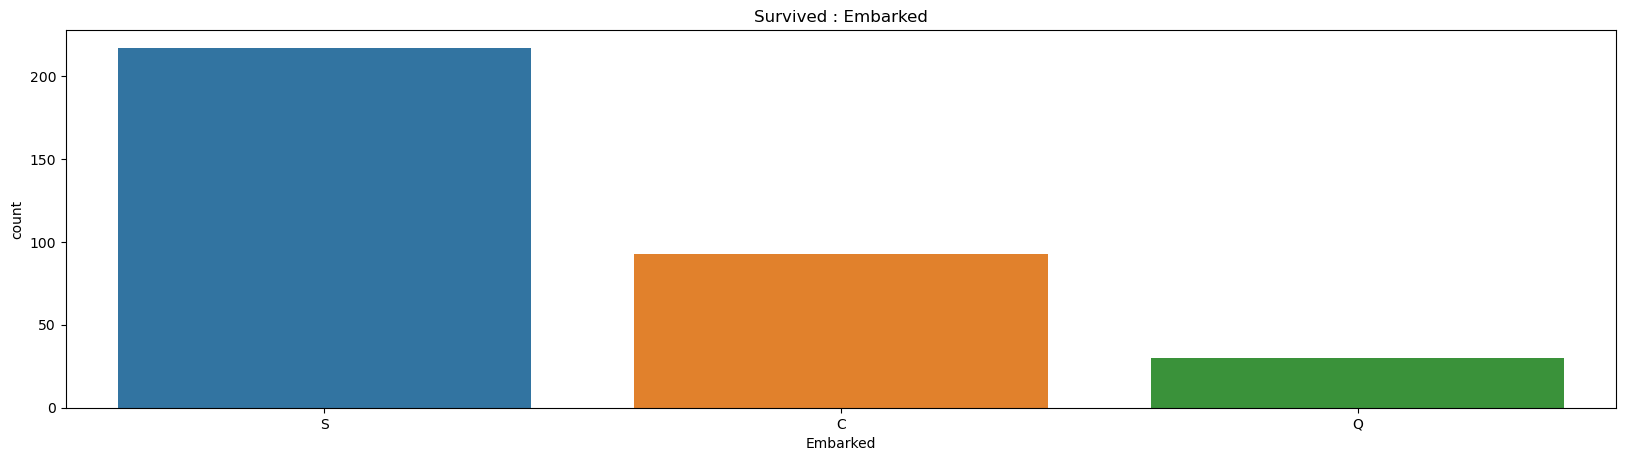

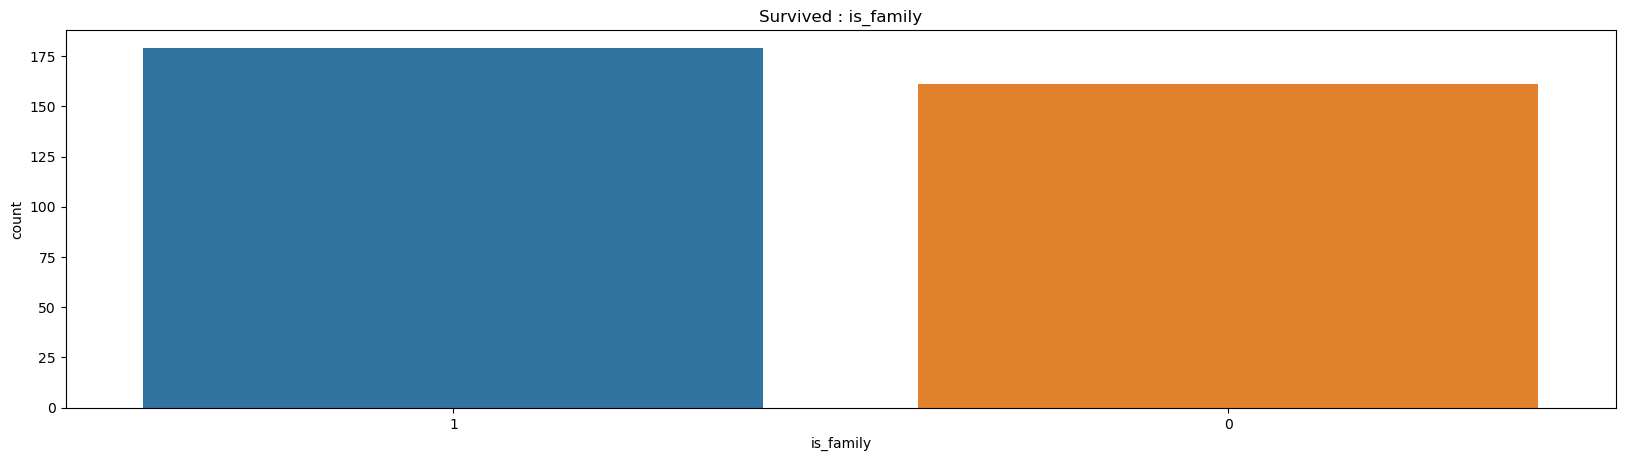

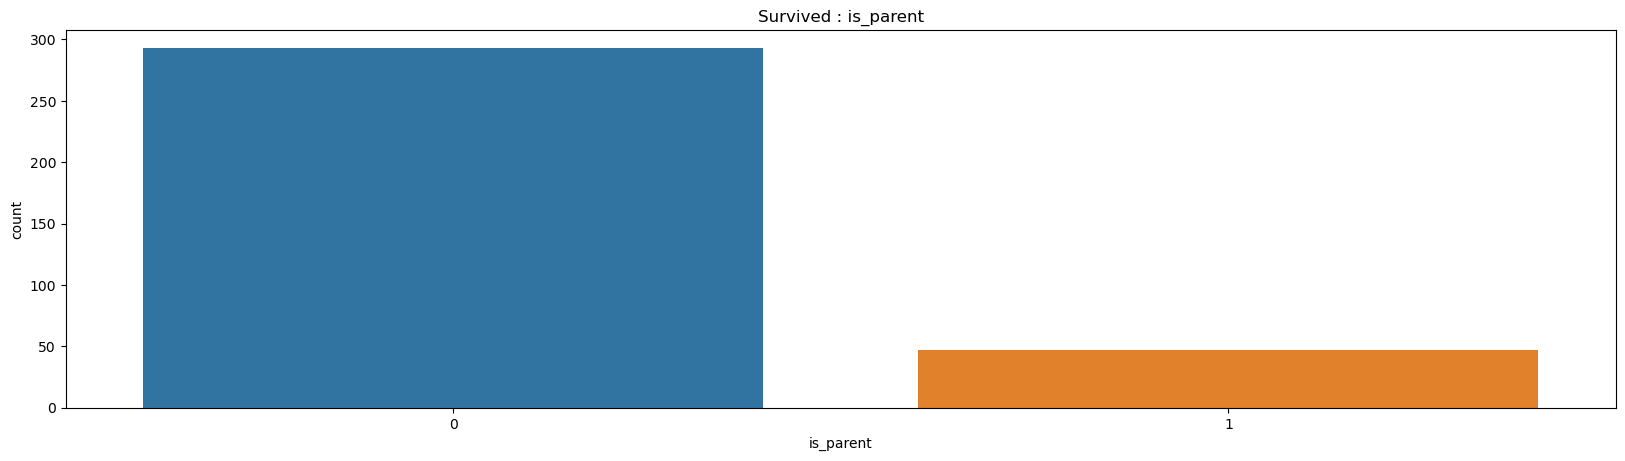

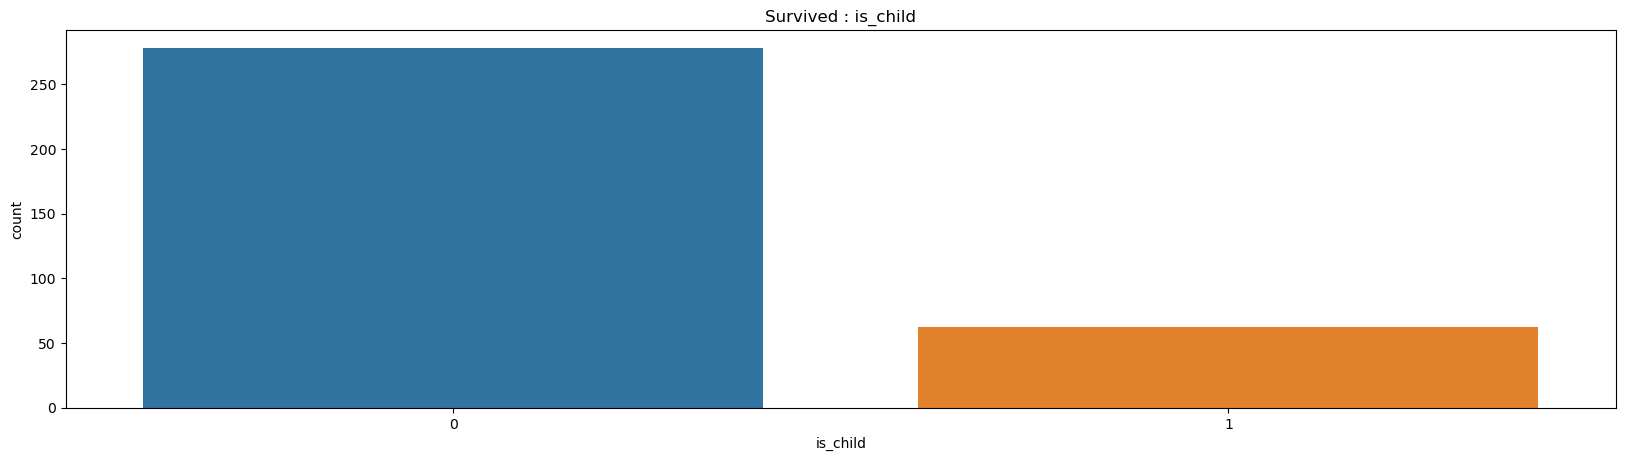

In [66]:
fields = ["Pclass","is_female","Embarked","is_family", "is_parent", "is_child"]
for field in fields:
    count_plot(surv_df, field)

## Fare and Age

These need to be bucketed to bring any meaning. First to find out what the values look like.

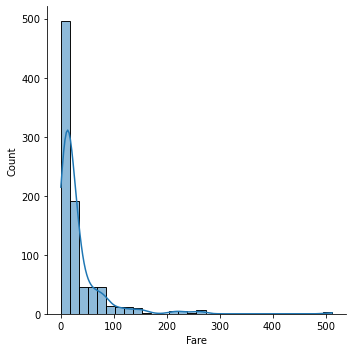

In [67]:
sns.displot(df, x="Fare", bins=30, kde=True);

<AxesSubplot:>

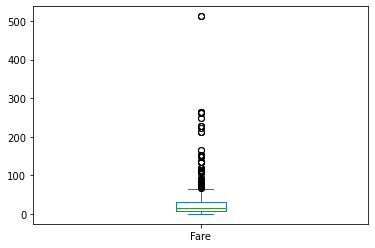

In [68]:
df["Fare"].plot(kind="box")

In [69]:
df[['Fare', "Survived"]].sort_values("Fare")

,Fare,Survived
271,0.0000,1
597,0.0000,0
302,0.0000,0
633,0.0000,0
277,0.0000,0
...,...,...
341,263.0000,1
88,263.0000,1
737,512.3292,1
679,512.3292,1


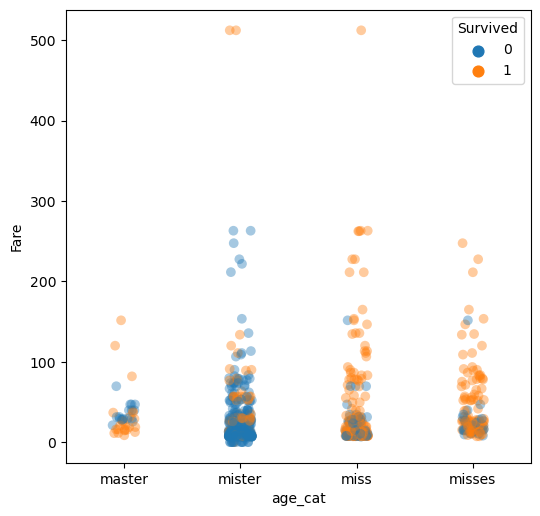

In [74]:
plt.figure(figsize=(6,6),dpi=100)
ax = sns.stripplot(x="age_cat", y="Fare", data=df, hue="Survived", 
                   s=7, alpha=0.4, 
                   order=["master", "mister", "miss", "misses"]);

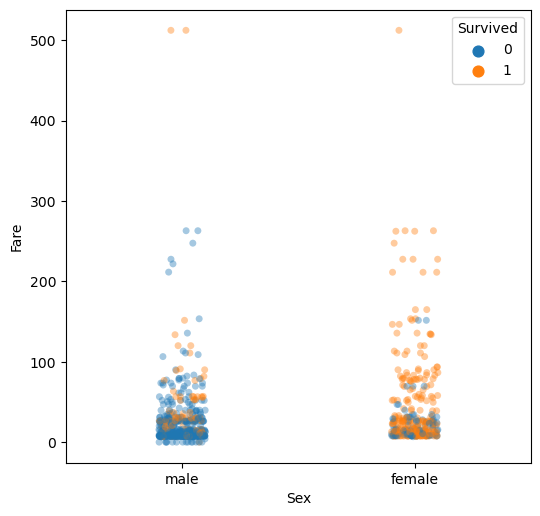

In [75]:
plt.figure(figsize=(6,6),dpi=100)
ax = sns.stripplot(data=df, x="Sex", y="Fare", hue="Survived", alpha=0.4);

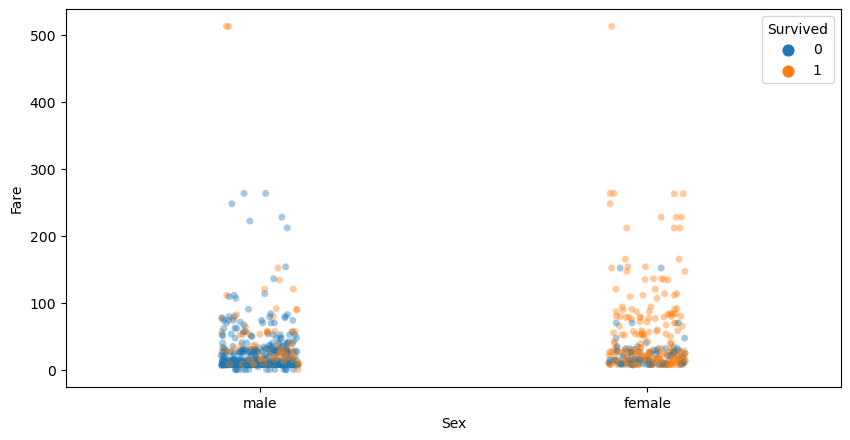

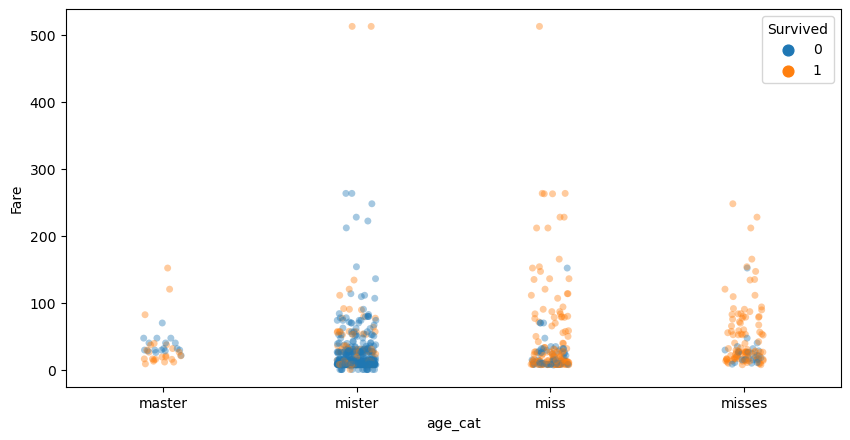

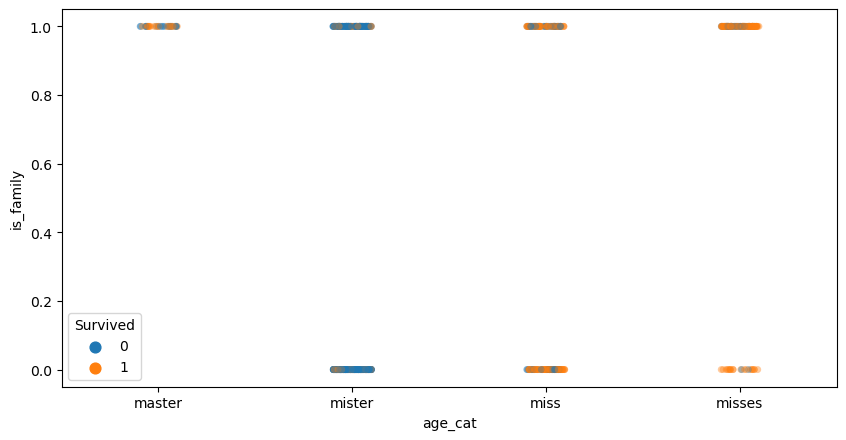

In [93]:
def strip_by_fields(df, x, y, order=None):
    plt.figure(figsize=(10,5),dpi=100)
    sns.stripplot(data=df.sort_values(field), x=x, y=y, hue="Survived",
                    alpha=0.4, order=order);
    plt.show();



strip_by_fields(df, "Sex", "Fare")
strip_by_fields(df, "age_cat", "Fare", order=["master", "mister", "miss", "misses"])
strip_by_fields(df, "age_cat", "is_family", order=["master", "mister", "miss", "misses"])
# strip_by_field(df, "Age")
# strip_by_field(df, "is_female")

<AxesSubplot:>

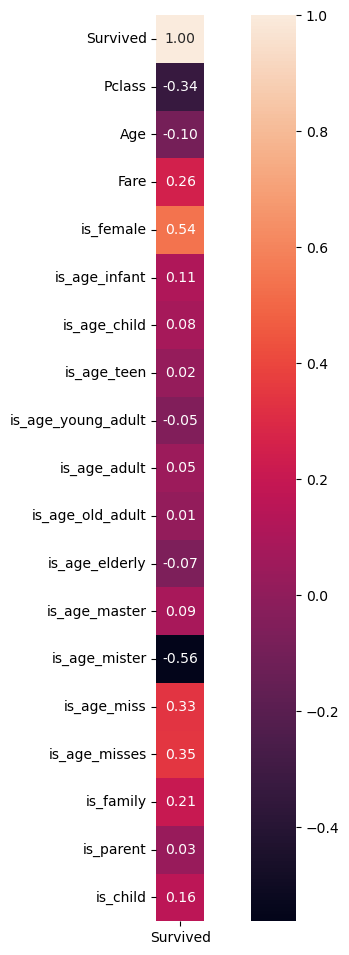

In [123]:
plt.figure(figsize=(12,12),dpi=100)
sns.heatmap(data=df.corr()[["Survived"]], square=True, annot=True, 
            fmt=".2f"
            # center=0,
            # cmap="viridis"
            # cmap="cubehelix"
            # cmap="YlOrBr"
            # cmap="vlag"
            # cmap="coolwarm_r"
            )

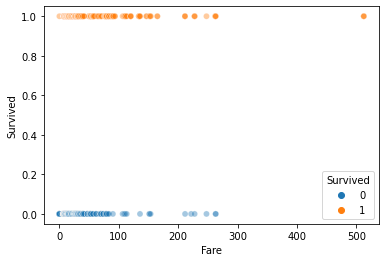

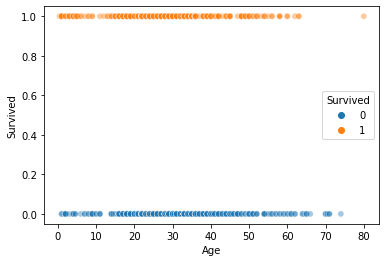

In [88]:
def scat_by_field(df, field):
    sns.scatterplot(data=df.sort_values(field), x=field, y="Survived", hue="Survived",
                    alpha=0.4);
    plt.show();
scat_by_field(df, "Fare")
scat_by_field(df, "Age")